In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint

In [15]:
#define parameters and initial values

lambd = np.array([10,10,10]) #repressor production rates

K = np.array([0.05,0.1,0.1]) # Michaelis-Menten constants of repression

N_0 = 10 #Plasmid copy number

n = np.array([1.5,1.5,1.5]) #Hill coefficients

p = np.array([2200,0,0]) #initial repressor numbers


In [16]:
#define propensity vector

a = np.array([lambda lambd, K, N_0, n, p:   lambd[0]*N_0*(K[2]**n[2])/(K[2]**n[2]+p[2]**n[2]), #a[0-2]: repressor synthesis
              lambda lambd, K, N_0, n, p:   lambd[1]*N_0*(K[0]**n[0])/(K[0]**n[0]+p[0]**n[0]),
              lambda lambd, K, N_0, n, p:   lambd[2]*N_0*(K[1]**n[1])/(K[1]**n[1]+p[1]**n[1]),
              lambda p: p[0],                                                               #a[3-5]: repressor dilution/segregation
              lambda p: p[1],
              lambda p: p[2]])

#calculate a_0: the sum of reaction rates, total rate for a reaction to happen

a_0 = 0

for i in range(0,3):
    
    a_0 += a[i](lambd,K, N_0, n, p) 

for i in range(3,6):
    
    a_0 += a[i](p)

In [17]:
#parameters for stochastic simulation

#sim_T = 50 #simulation time

step_num = 30000 #number of time steps to be simulated

#Total simulated time (unit is average protein lifetime)

T = 0

#mean of geometrically distributed translational burst b

b_mean = 10

#Matrix where simulation is stored. It has the form [[tau_0, p[0]_0, p[1]_0, p[2]_0]
#                                                    [tau_1, p[0]_1, p[1]_1, p[2]_1]
#                                                    [tau_2, p[0]_2, p[1]_2, p[2]_2]
#                                                    [ ... ,  ...  ,  ...  ,  ...  ]]  

sim = np.zeros((step_num+1,4))

#save initial values

sim[0][0] = T

for i in range(0,3):
    sim[0][i+1] = p[i]

In [18]:
#Gillespie Direct Algorithm

for index in range(1,step_num+1):
    
    #Determine first time step

    tau = np.random.exponential(1/a_0) #Draw time step from exponential distribution with mean 1/a_0 

    #Determine which reaction will happen

    rho = np.random.random() #generate random number from a homogeneous distribution in [0,1[
#    print(rho)
    r1 = a[0](lambd,K, N_0, n, p)/a_0
    
    r2 = (a[0](lambd,K, N_0, n, p)+a[1](lambd,K, N_0, n, p))/a_0
    
    r3 = (a[0](lambd,K, N_0, n, p)+a[1](lambd,K, N_0, n, p)+a[2](lambd,K, N_0, n, p))/a_0
    
    r4 = (a[0](lambd,K, N_0, n, p)+a[1](lambd,K, N_0, n, p)+a[2](lambd,K, N_0, n, p)+a[3](p))/a_0
    
    r5 = (a[0](lambd,K, N_0, n, p)+a[1](lambd,K, N_0, n, p)+a[2](lambd,K, N_0, n, p)+a[3](p)+a[4](p))/a_0
    
    r6 = (a[0](lambd,K, N_0, n, p)+a[1](lambd,K, N_0, n, p)+a[2](lambd,K, N_0, n, p)+a[3](p)+a[4](p)+a[5](p))/a_0
    
#    print(a_1,a_0,r1,r2,r3,r4,r5,r6)
    if 0 <= rho <r3:
        
        #determine size of translational burst b, which is geometrically distributed with mean <b>=1/p

        b = np.random.geometric(1/b_mean)

        if 0 <= rho < r1:
            p[0] += b
            #print('reaction 1')
        
        elif r1 <= rho < r2:
            p[1] += b
            #print('reaction 2')
   
        elif r2 <= rho < r3:
            p[2] += b   
            #print('reaction 3')
        
    elif r3 <= rho < r4:
        if p[0] >= 1:
            p[0] -= 1  
            #print('reaction 4')
            
    elif r4 <= rho < r5:
        if p[1] >= 1:
            p[1] -= 1 
            #print('reaction 5')
            
    elif r5 <= rho < 1:
        if p[2] >= 1:
            p[2] -= 1  
            #print('reaction 6')

    #update total time
    
    T += tau
    
    #save simulated values
    
    sim[index][0] = T

    for i in range(0,3):
        sim[index][i+1] = p[i]
    
    #update a_0
    a_0 = 0
    for i in range(0,3):
    
        a_0 += a[i](lambd,K, N_0, n, p) 

    for i in range(3,6):
    
        a_0 += a[i](p)

#print(sim)  
print('Total simulation time in average protein life-times: T=',T) 
print('Total simulation time in minutes (average protein life-time 45 min): T=',T*45) 


Total simulation time in average protein life-times: T= 32.586619772674574
Total simulation time in minutes (average protein life-time 45 min): T= 1466.3978897703557


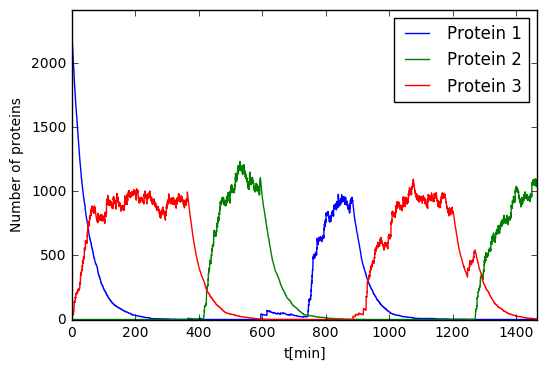

In [19]:
plt.plot(sim[:,0]*45,sim[:,1], label='Protein 1')
plt.plot(sim[:,0]*45,sim[:,2], label='Protein 2')
plt.plot(sim[:,0]*45,sim[:,3], label='Protein 3')
maxim = max([np.amax(sim,axis=0)[1],np.amax(sim,axis=0)[2],np.amax(sim,axis=0)[3]])
plt.axis([0, T*45, 0, maxim+0.1*maxim])
plt.xlabel('t[min]')
plt.ylabel('Number of proteins')
plt.legend()
plt.show()

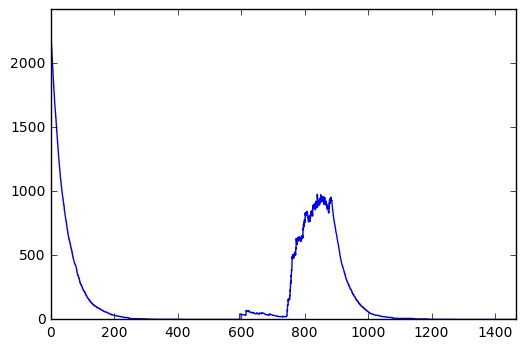

In [20]:
plt.plot(sim[:,0]*45,sim[:,1], label='Protein 1')
plt.axis([0, T*45, 0, np.amax(sim,axis=0)[1]+0.1*np.amax(sim,axis=0)[1]])
plt.show()

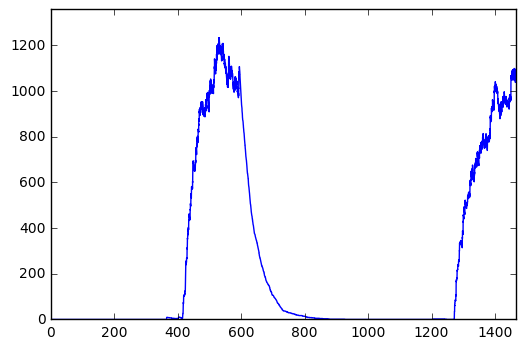

In [21]:
plt.plot(sim[:,0]*45,sim[:,2], label='Protein 2')
plt.axis([0, T*45, 0, np.amax(sim,axis=0)[2]+0.1*np.amax(sim,axis=0)[2]])
plt.show()

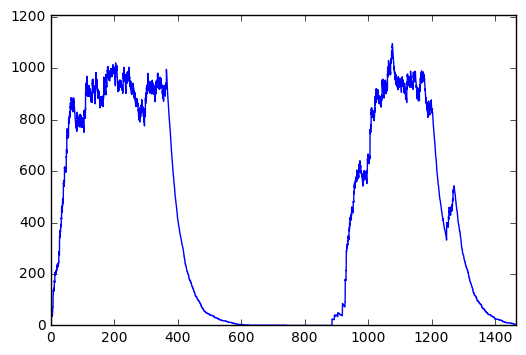

In [22]:
plt.plot(sim[:,0]*45,sim[:,3], label='Protein 3')
plt.axis([0, T*45, 0, np.amax(sim,axis=0)[3]+0.1*np.amax(sim,axis=0)[3]])
plt.show()